# Lab Environmental Comfort Index (LECI)  

## Phase 1 — Project Setup  

### Step 1: Define Research Problem  

**Project Concept**  
Develop a **species-agnostic computational framework** to quantify environmental comfort in laboratory animals.  
- **Initial focus:** Zebrafish (widely used vertebrate model).  
- **Scalability:** Methodology adaptable to rodents, rabbits, and other species.  
- **Goal:** Objectively quantify environmental quality in tanks to improve welfare and reproducibility.  

<p align="center">
  <img src="https://nc3rs.org.uk/sites/default/files/styles/image_16_9/public/2022-01/Fish%20tanks%20in%20an%20aquarium%20blue.jpg?itok=REe5e3Fe" 
       alt="Zebrafish Tank Setup" width="900"/>
  <div style="font-size:0.8em; color:gray; text-align:center; margin-top:4px;">
    Image courtesy of <a href="https://nc3rs.org.uk/our-portfolio/detection-assessment-and-alleviation-pain-laboratory-zebrafish" target="_blank">NC3Rs</a>
  </div>
</p>  

---

### Why Zebrafish? (Biological/Veterinary Rationale)  
- Highly sensitive to **environmental parameters** (temperature, dissolved oxygen, pH, etc.).  
- Small size, high fecundity, and strong genetic similarity to humans → reproducible experiments.  
- Ideal candidate for building a **scalable comfort index**.  

---

### Environmental Comfort Index (ECI)  

**Purpose:** Create a **standardized 0–100 score** for zebrafish tank conditions.  

**Comfort Categories:**  
- **Low Comfort:** 0–39  
- **Medium Comfort:** 40–69  
- **High Comfort:** 70–100  

**Features Included:**  
- **Water quality:** Temperature, pH, dissolved oxygen, hardness, nitrogen load, flow rate  
- **Tank environment:** Substrate, noise level, light/dark cycle, room humidity, stocking density  

**Exclusions (Phase 1):**  
- Behavioral data  
- Enrichment activities  
- Inter-species interactions  

**Scope:** Focused on **static environmental parameters** for reproducibility and reduced model complexity.  

---

### Machine Learning Rationale  

- **Target variable:** ECI (continuous score)  
- **Predictors:** Environmental features  
- **Models evaluated:**  
  - Linear Regression  
  - Ridge Regression  
  - Random Forest Regressor  
  - Gradient Boosted Trees (**best performer**)  
- **Overfitting prevention:** Cross-validation, feature regularization, exclusion of dynamic factors  

---

### Significance  

- **Animal Welfare & the 3Rs**  
  - **Refinement:** Continuous, objective measure of tank comfort.  
  - **Reduction:** Improved reproducibility lowers the need for repeated studies.  
  - **Replacement (indirect):** Strengthens zebrafish as a validated non-mammalian alternative model.  

- **Veterinary Application**  
  Provides **real-time, data-driven insights** into zebrafish housing quality, enabling proactive interventions.  

- **Scientific Reproducibility**  
  Standardized comfort scoring reduces environmental variability, strengthening reliability of experimental findings.  

- **Operational Efficiency**  
  Automates environmental assessment → minimizes manual recording & subjective judgment.  

- **Regulatory Alignment**  
  Supplies auditable, quantitative evidence for **IACUC** and **AAALAC** compliance.  

---

### Previous Work & Continuity  

- Builds on the [**Lab Animal Growth Prediction**](https://github.com/Ibrahim-El-Khouli/Lab-Animal-Growth-Prediction) framework (murine growth).  
- Extends the scope from **growth modeling → environmental comfort assessment**.  
- Introduces:  
  - Realistic datasets  
  - Expanded model toolkit (Linear, Ridge, Random Forest, Gradient Boosted Trees)  
- **Gradient Boosted Trees** emerged as the **most effective and precise**, reproducible for deployment.  


### Step 2: Import Libraries  

We now prepare the software environment.  

**Core Libraries:**  
- `numpy`, `pandas` → data handling and numerical operations  

**Visualization:**  
- `matplotlib.pyplot`, `seaborn` → exploratory data analysis, distribution plots, correlations  

**Modeling:**  
- `scikit-learn`  
  - Regression models: `LinearRegression`, `Ridge`, `RandomForestRegressor`, `GradientBoostingRegressor`  
  - Model selection & evaluation: `train_test_split`, `cross_val_score`  
  - Pipelines & preprocessing: `Pipeline`, `ColumnTransformer`, `StandardScaler`, `OneHotEncoder`  
  - Inspection & explainability: `PartialDependenceDisplay`, `set_config`  

**Explainability:**  
- `shap` → model interpretability  

**Utilities:**  
- `joblib`, `os`, `warnings` → saving/loading models, managing files, suppressing warnings  

**Rationale:**  
- **Biological:** Enables transparent, reproducible analysis for veterinary and welfare reporting.  
- **ML:** Establishes a robust, modular coding environment for reusability across species and datasets.


In [218]:
# Step 2: Import Libraries

# --- General Purpose ---
import os
import warnings
import joblib
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn: Model Selection ---
from sklearn.model_selection import train_test_split, cross_val_score

# --- Scikit-learn: Models ---
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# --- Scikit-learn: Utilities ---
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from sklearn import set_config

# --- Explainability ---
import shap

# --- Settings ---
warnings.filterwarnings("ignore")

## Phase 2 — Data Creation & Exploration  

### Step 1: Synthetic Dataset Generation  

**Biological/Veterinary Rationale:**  
- Lab conditions must remain within safe physiological ranges for zebrafish.  
- Deviations (temperature, DO, nitrogen, etc.) cause stress → lower welfare → lower ECI score.  
- Random noise (±5%) is added to simulate real-world measurement variation.  

**Machine Learning Rationale:**  
- A synthetic dataset allows prototyping without needing sensitive animal facility data.  
- Balanced sampling across ranges avoids biased models.  
- ECI scoring rules → provide initial “labels” for supervised regression.  

**Dataset Size:**  
- 2,000 tank samples → enough to train/test ML without overfitting.  

**Features & Ranges:**  
- Temperature (°C): 26–28  
- Dissolved Oxygen (DO) (mg/L): ≥6  
- pH: 6.8–7.5  
- Hardness (ppm): 50–150  
- Humidity (%): 40–60  
- Substrate: Sand / Gravel / Bare Glass  
- Noise: Low / Medium / High  
- Light/Dark: 14/10, 12/12, 10/14  
- Density (fish/L): 3–5  
- Nitrogen load (Ammonia + Nitrite + Nitrate) (mg/L): <50  
- Flow rate: Low / Medium / High  

**Scoring Rules:**  
- Full points = optimal range  
- Mild deviation = partial deduction  
- Severe deviation = strong deduction  
- Normalize all scores to 0–100  


In [220]:
# Step 1: Synthetic Dataset Generation

# Number of samples
n_samples = 2000  

# Generate continuous features with noise ±5% noise for realism
temperature = np.random.uniform(26, 28, n_samples) * np.random.normal(1, 0.05, n_samples)
do = np.random.uniform(5, 8, n_samples) * np.random.normal(1, 0.05, n_samples)
ph = np.random.uniform(6.5, 7.8, n_samples) * np.random.normal(1, 0.05, n_samples)
hardness = np.random.uniform(40, 160, n_samples) * np.random.normal(1, 0.05, n_samples)
humidity = np.random.uniform(35, 65, n_samples) * np.random.normal(1, 0.05, n_samples)
density = np.random.uniform(2, 7, n_samples) * np.random.normal(1, 0.05, n_samples)
nitrogen = np.random.uniform(10, 70, n_samples) * np.random.normal(1, 0.05, n_samples)

# Categorical features
substrate = np.random.choice(["sand", "gravel", "glass"], n_samples)
noise = np.random.choice(["low", "medium", "high"], n_samples)
light = np.random.choice(["14/10", "12/12", "10/14"], n_samples)
flow = np.random.choice(["low", "medium", "high"], n_samples)

# Initialize DataFrame
df = pd.DataFrame({
    "Temperature (°C)": temperature,
    "Dissolved Oxygen (mg/L)": do,
    "PH": ph,
    "Hardness (ppm)": hardness,
    "Humidity (%)": humidity,
    "Density (fish/L)": density,
    "Nitrogen Load (mg/L)": nitrogen,
    "Substrate": substrate,
    "Noise Level": noise,
    "Light-Dark Cycle": light,
    "Water Flow": flow
})

# --- Corrected Scoring Function ---
def score_environment(row):
    score = 100
    
    # Temperature (°C): 26–28
    if 26 <= row["Temperature (°C)"] <= 28:
        pass
    elif 25 <= row["Temperature (°C)"] <= 29:
        score -= 10
    else:
        score -= 25
    
    # Dissolved Oxygen                                           
    if row["Dissolved Oxygen (mg/L)"] >= 6:
        pass
    elif row["Dissolved Oxygen (mg/L)"] >= 5:
        score -= 15
    else:
        score -= 30
    
    # pH
    if 6.8 <= row["PH"] <= 7.5:
        pass
    elif 6.5 <= row["PH"] <= 7.8:
        score -= 10
    else:
        score -= 20
    
    # Hardness
    if 50 <= row["Hardness (ppm)"] <= 150:
        pass
    else:
        score -= 10
    
    # Humidity
    if 40 <= row["Humidity (%)"] <= 60:
        pass
    else:
        score -= 5
    
    # Density
    if 3 <= row["Density (fish/L)"] <= 5:
        pass
    elif 2 <= row["Density (fish/L)"] <= 6:
        score -= 10
    else:
        score -= 20
    
    # Nitrogen
    if row["Nitrogen Load (mg/L)"] < 50:
        pass
    elif row["Nitrogen Load (mg/L)"] < 60:
        score -= 15
    else:
        score -= 30
    
    # Categorical penalties
    if row["Substrate"] == "glass":
        score -= 5
    if row["Noise Level"] == "high":
        score -= 15
    if row["Light-Dark Cycle"] != "14/10":
        score -= 5
    if row["Water Flow"] == "low":
        score -= 10
    
    return max(0, min(100, score))

# Apply scoring
df["ECI"] = df.apply(score_environment, axis=1)
df

,Temperature (°C),Dissolved Oxygen (mg/L),PH,Hardness (ppm),Humidity (%),Density (fish/L),Nitrogen Load (mg/L),Substrate,Noise Level,Light-Dark Cycle,Water Flow,ECI
0,30.372518,5.292923,8.099851,57.718761,49.030987,2.461611,20.397256,glass,medium,14/10,low,15
1,27.920479,5.347892,7.801680,56.924053,35.671796,7.252797,42.925843,glass,high,12/12,medium,15
2,26.888711,6.333384,7.084413,79.046753,59.858507,4.103540,23.284450,glass,medium,12/12,low,80
3,28.432783,5.312331,7.193658,148.027055,62.216874,4.284950,29.246948,sand,low,10/14,high,65
4,28.051464,5.706185,7.268789,110.644852,65.463188,5.509417,35.650382,glass,medium,12/12,medium,50
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,28.125774,5.283199,6.834951,129.803500,42.454030,6.336950,52.830703,glass,high,12/12,medium,15
1996,26.325762,5.593180,7.300378,82.967158,55.194351,3.251888,26.940920,sand,high,14/10,medium,70
1997,25.158593,6.523147,7.457711,51.242009,39.663688,6.913283,36.993958,sand,low,10/14,medium,60
1998,27.106738,6.018494,7.211491,83.409006,38.456436,5.273895,47.224912,gravel,medium,12/12,low,70


### Step 2: Data Quality Checks

**Biological/Vet Rationale:**  
- Ensures all environmental values remain within physiologically safe ranges for zebrafish.  
- Identifies potential outliers or unrealistic tank conditions before modeling.

**Machine Learning Rationale:**  
- Prevents garbage-in, garbage-out issues (GIGO).  
- Ensures balanced distribution across comfort categories for better model training.

**Tasks:**  
1. Verify numeric features are within defined valid ranges.  
2. Check balance of comfort categories: Low (0–39), Medium (40–69), High (70–100).  
3. Optionally flag or handle outliers.


In [222]:
# Step 3: Data Quality Checks

# 1. Check numeric ranges
numeric_features = [
    "Temperature (°C)", 
    "Dissolved Oxygen (mg/L)", 
    "PH", 
    "Hardness (ppm)", 
    "Humidity (%)", 
    "Density (fish/L)", 
    "Nitrogen Load (mg/L)"
]

for feature in numeric_features:
    print(f"{feature} range: {df[feature].min():.2f} - {df[feature].max():.2f}")

# 2. Check distribution of ECI categories
def categorize_eci(score):
    if score < 40:
        return "Low"
    elif score < 70:
        return "Medium"
    else:
        return "High"

df["Comfort Category"] = df["ECI"].apply(categorize_eci)
print(df["Comfort Category"].value_counts())

# 3. flag outliers (example using IQR method)
for feature in numeric_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)]
    print(f"{feature} outliers: {len(outliers)}")

Temperature (°C) range: 21.86 - 32.11
Dissolved Oxygen (mg/L) range: 4.51 - 9.40
PH range: 5.60 - 8.85
Hardness (ppm) range: 37.21 - 178.05
Humidity (%) range: 31.05 - 75.46
Density (fish/L) range: 1.74 - 7.66
Nitrogen Load (mg/L) range: 9.27 - 77.34
Comfort Category
Medium    970
Low       619
High      411
Name: count, dtype: int64
Temperature (°C) outliers: 21
Dissolved Oxygen (mg/L) outliers: 0
PH outliers: 6
Hardness (ppm) outliers: 0
Humidity (%) outliers: 0
Density (fish/L) outliers: 0
Nitrogen Load (mg/L) outliers: 0


### Step 3: Exploratory Data Analysis (EDA)

**Biological/Vet Rationale:**  
- Helps visualize how environmental parameters vary across tanks.  
- Detects potential stressors or imbalances in housing conditions.  
- Ensures zebrafish welfare parameters are within safe ranges before modeling.

**Machine Learning Rationale:**  
- Identifies correlated features, skewed distributions, or outliers that may affect model performance.  
- Guides feature engineering and preprocessing decisions.

**Tasks:**  
1. Summary statistics: mean, median, std.  
2. Correlation heatmap: detect co-varying features.  
3. Distribution plots: spot skewed variables.  
4. Boxplots: highlight outliers.  
5. Scatterplot: visualize deviation from optimal ranges.

In [224]:
# Step 4: Exploratory Data Analysis (EDA)

# 1. Summary statistics
print(df.describe())

       Temperature (°C)  Dissolved Oxygen (mg/L)           PH  Hardness (ppm)  \
count       2000.000000              2000.000000  2000.000000     2000.000000   
mean          27.067559                 6.520484     7.155580      100.229435   
std            1.483557                 0.930291     0.517283       35.170855   
min           21.857061                 4.510663     5.604356       37.211522   
25%           26.085162                 5.760298     6.780812       69.464404   
50%           27.098612                 6.489293     7.146397      100.342667   
75%           28.018611                 7.270635     7.519161      129.813874   
max           32.105026                 9.395680     8.850391      178.052716   

       Humidity (%)  Density (fish/L)  Nitrogen Load (mg/L)          ECI  
count   2000.000000       2000.000000           2000.000000  2000.000000  
mean      50.124377          4.521435             39.872076    47.887500  
std        9.146027          1.470090        

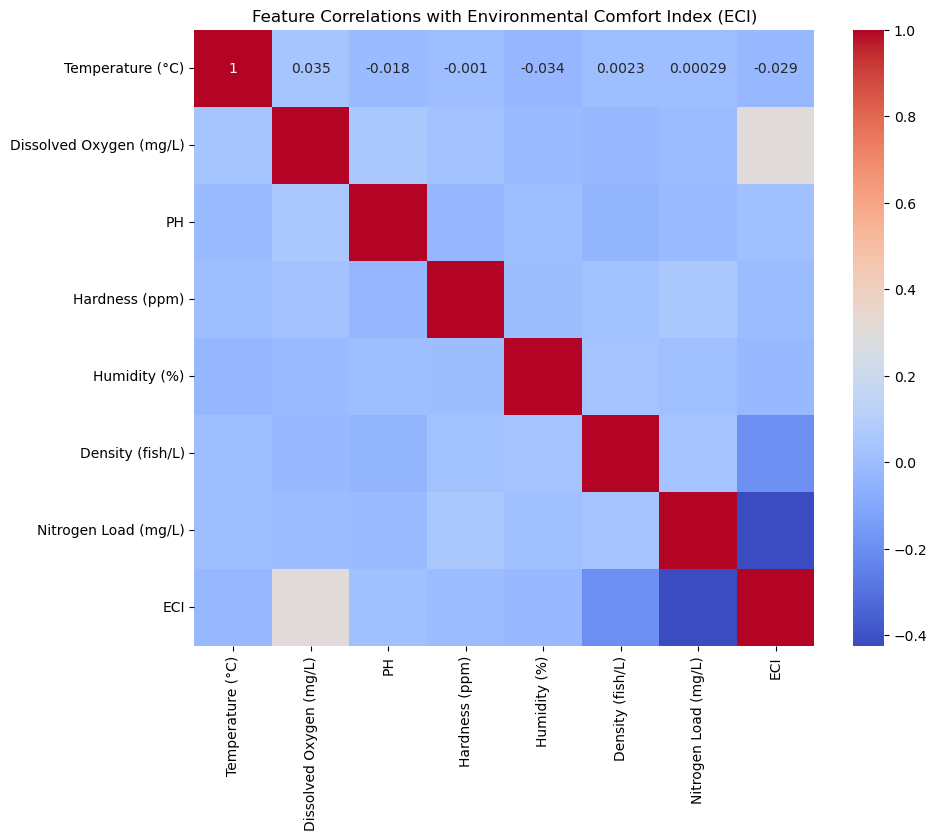

In [225]:
# 2. Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features + ["ECI"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations with Environmental Comfort Index (ECI)")
plt.show()

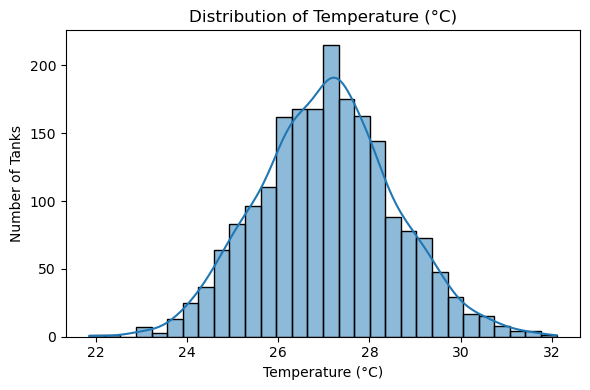

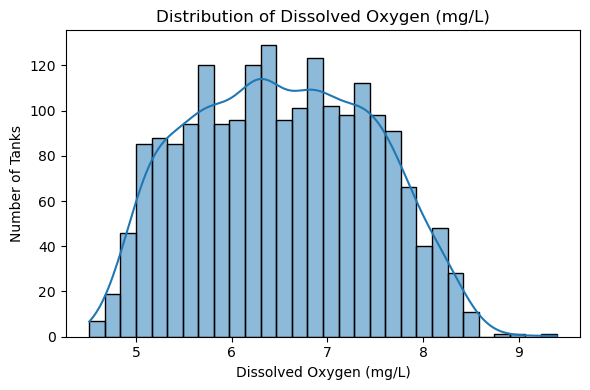

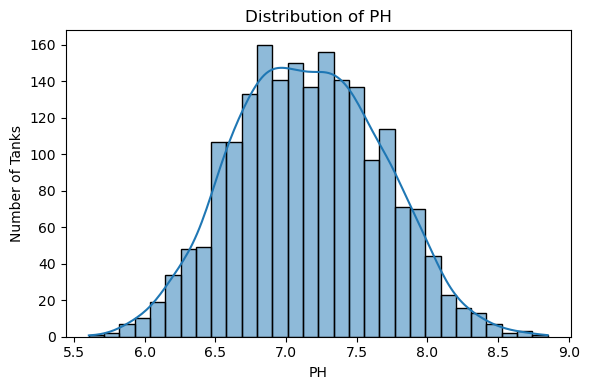

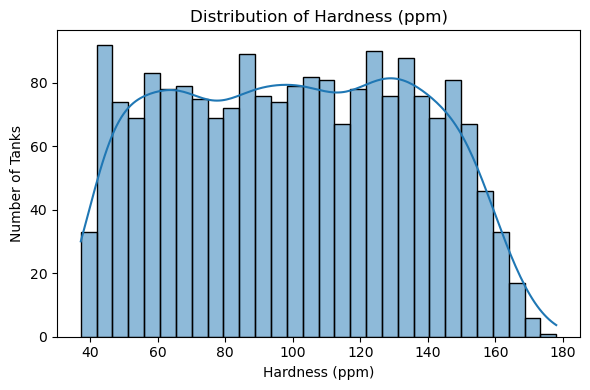

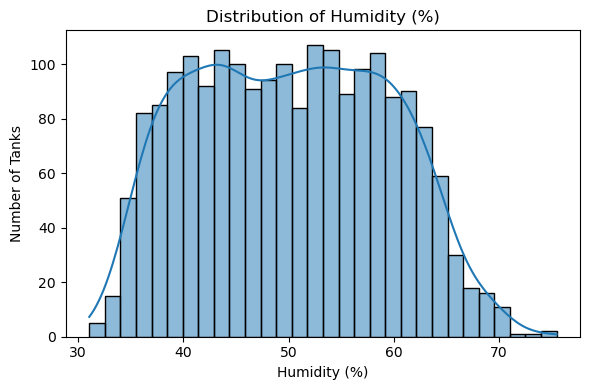

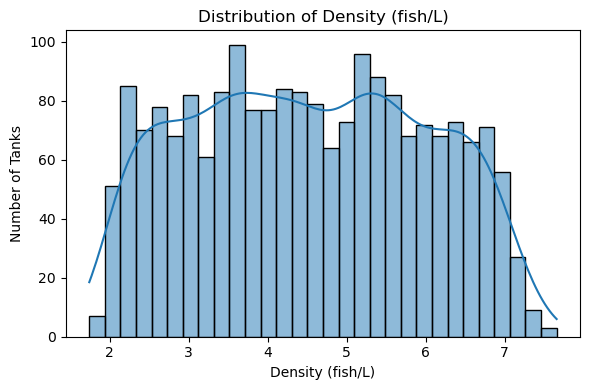

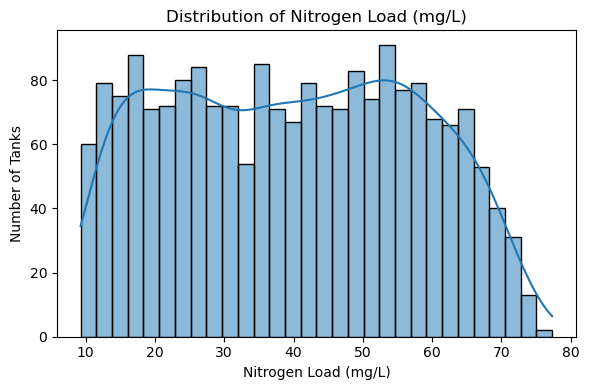

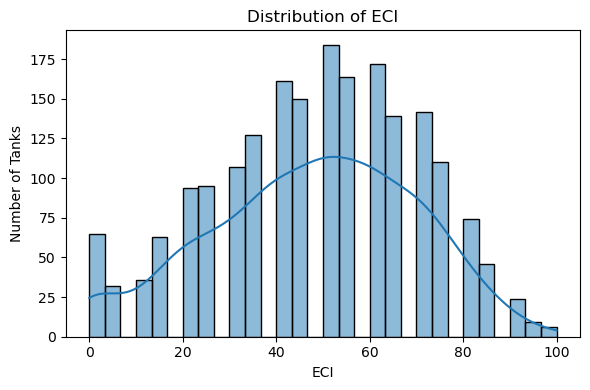

In [226]:
# Distribution plots with clear separation
for feature in numeric_features + ["ECI"]:
    plt.figure(figsize=(6,4))  
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Number of Tanks')
    plt.tight_layout() 
    plt.show()          
    
    # Separation line in notebook output
    print("\n" + "="*90 + "\n")

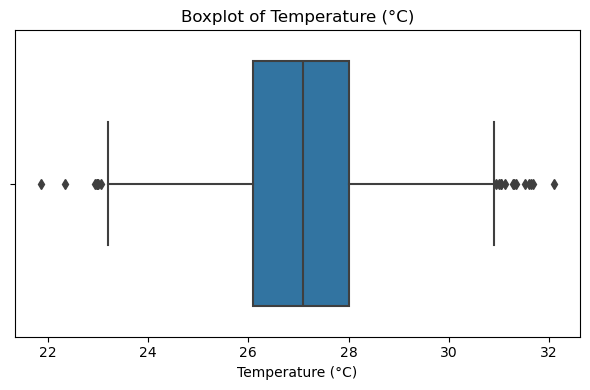

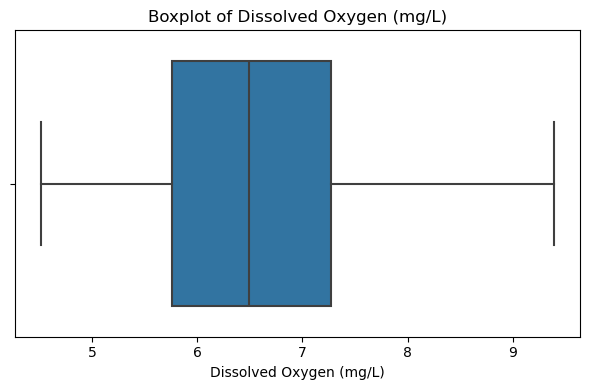

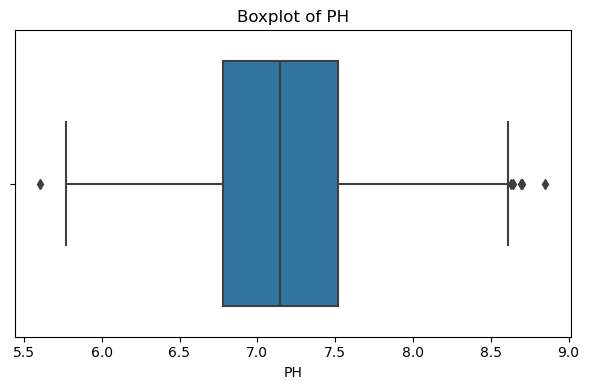

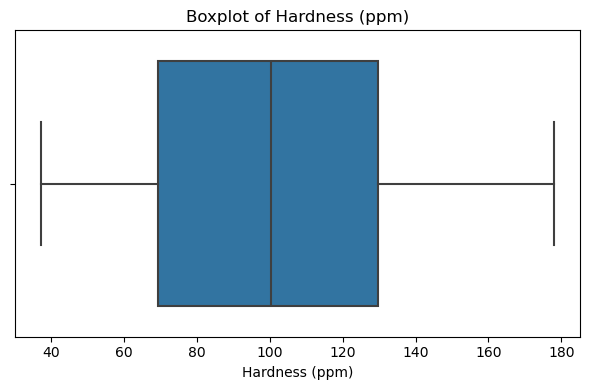

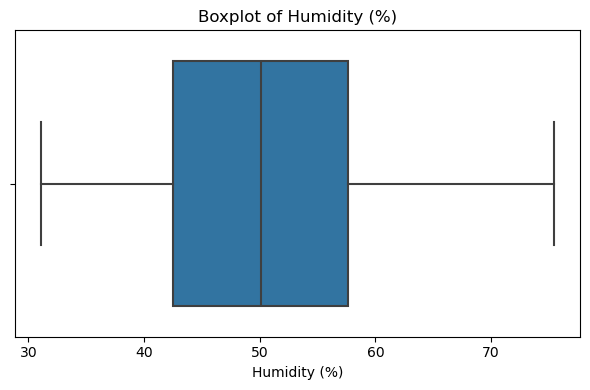

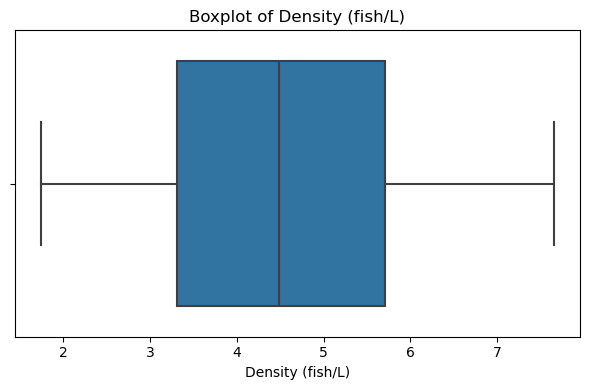

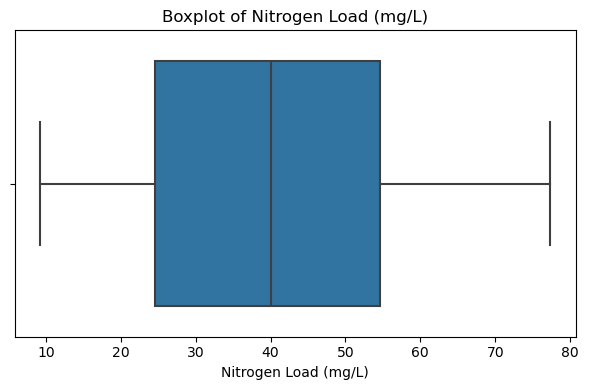

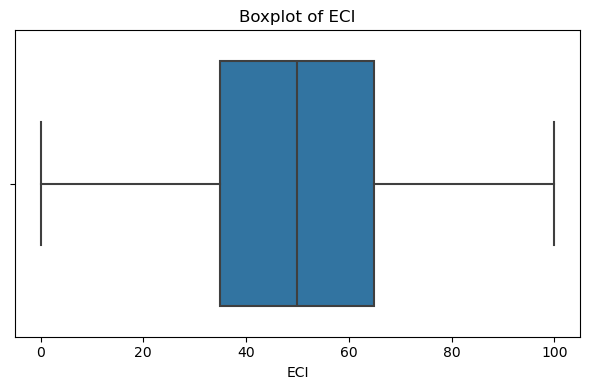

In [227]:
# Boxplots to check outliers
for feature in numeric_features + ["ECI"]:
    plt.figure(figsize=(6,4))          
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)
    plt.tight_layout()                   
    plt.show()                           

    # Separation line in notebook output
    print("\n" + "="*90 + "\n")


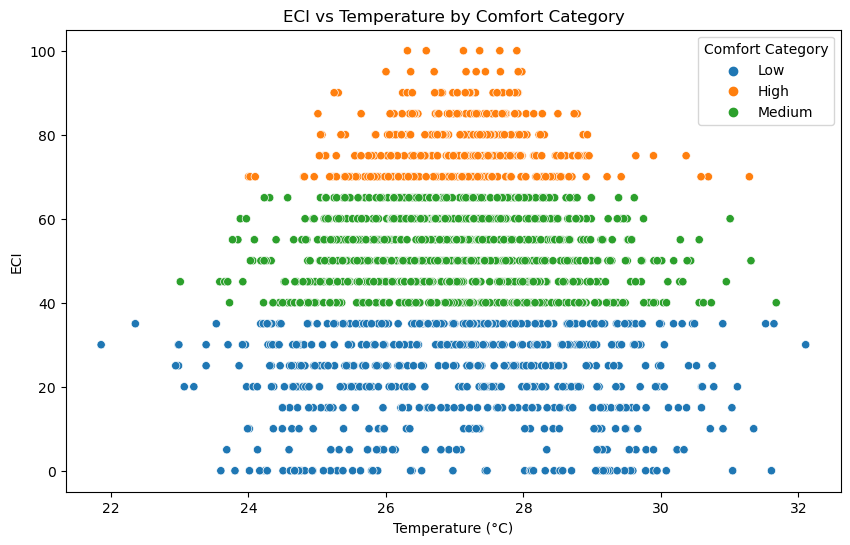

In [228]:
# 5. visualize deviation from optimal
plt.figure(figsize=(10,6))
sns.scatterplot(x="Temperature (°C)", y="ECI", hue="Comfort Category", data=df)
plt.title("ECI vs Temperature by Comfort Category")
plt.show()

## Phase 3 — Feature Preparation  

### Step 1: Feature Encoding

**Biological/Vet Rationale:**  
- Categorical tank/environment features need numeric representation for ML, but we preserve their biological meaning.  
- Example: `Substrate` affects stress & waste accumulation, `Noise Level` affects chronic stress.  

**Machine Learning Rationale:**  
- One-hot encoding converts categories into binary columns for regression models.  
- Drop-first avoids multicollinearity for linear models.  

**Tasks:**  
1. One-hot encode categorical features:  
   - `Substrate`  
   - `Noise Level`  
   - `Light-Dark Cycle`  
   - `Water Flow`


In [230]:
# Phase 3 Step 1: Feature Encoding 

categorical_features = ["Substrate", "Noise Level", "Light-Dark Cycle", "Water Flow"]

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Check the new structure
df_encoded.head()

,Temperature (°C),Dissolved Oxygen (mg/L),PH,Hardness (ppm),Humidity (%),Density (fish/L),Nitrogen Load (mg/L),ECI,Comfort Category,Substrate_gravel,Substrate_sand,Noise Level_low,Noise Level_medium,Light-Dark Cycle_12/12,Light-Dark Cycle_14/10,Water Flow_low,Water Flow_medium
0,30.372518,5.292923,8.099851,57.718761,49.030987,2.461611,20.397256,15,Low,False,False,False,True,False,True,True,False
1,27.920479,5.347892,7.801680,56.924053,35.671796,7.252797,42.925843,15,Low,False,False,False,False,True,False,False,True
2,26.888711,6.333384,7.084413,79.046753,59.858507,4.103540,23.284450,80,High,False,False,False,True,True,False,True,False
3,28.432783,5.312331,7.193658,148.027055,62.216874,4.284950,29.246948,65,Medium,False,True,True,False,False,False,False,False
4,28.051464,5.706185,7.268789,110.644852,65.463188,5.509417,35.650382,50,Medium,False,False,False,True,True,False,False,True


### Step 2: Derived Features (Feature Engineering)

**Biological/Vet Rationale:**  
- Zebrafish thrive best at ~27 °C and dissolved oxygen ≥ 6 mg/L.  
- Alone, small deviations in temperature or oxygen may not be lethal, but **together they amplify stress** (e.g., warmer water holds less oxygen).  
- This is a **synergistic stress effect**: two mild stressors combine to create a major physiological burden.  
- Capturing these interactions reflects real-world biological conditions more accurately.

**Machine Learning Rationale:**  
- Models may miss nonlinear biological interactions if only raw features are provided.  
- Explicitly engineering derived features like this **encodes biological insight into the dataset**, improving interpretability and predictive power.  
- It also reduces the burden on the model to “discover” interactions from scratch.

**Task:**  
- Compute **Thermal-Oxygen Stress Index**:  

$$
\text{Stress} = \lvert \text{Temperature} - 27 \rvert \times \max(0,\, 6 - \text{Dissolved Oxygen})
$$

**Explanation of the Formula:**  
- $ \lvert \text{Temperature} - 27 \rvert $ → distance from the optimal 27 °C.  
- $ \max(0,\, 6 - \text{DO}) $ → contributes only if DO < 6 mg/L; otherwise 0.  
- Multiplying them → stress rises significantly **only when both conditions are poor** (temp deviation *and* low oxygen).  
- At ideal conditions (27 °C and DO ≥ 6) → Stress = 0.  

**Interpretation:**  
- Higher stress values correspond to lower **Environmental Comfort Index (ECI)**.  
- This feature highlights tanks that may seem “acceptable” by single parameters but become risky when stressors interact.


In [232]:
# Phase 3 Step 2: Derived Features (Feature Engineering)

# Thermal-Oxygen Stress Index
df_encoded["Thermal-Oxygen Stress"] = abs(df_encoded["Temperature (°C)"] - 27) * np.maximum(0, 6 - df_encoded["Dissolved Oxygen (mg/L)"])

# Quick check
df_encoded[["Temperature (°C)", "Dissolved Oxygen (mg/L)", "Thermal-Oxygen Stress"]].head()

,Temperature (°C),Dissolved Oxygen (mg/L),Thermal-Oxygen Stress
0,30.372518,5.292923,2.384630
1,27.920479,5.347892,0.600251
2,26.888711,6.333384,0.000000
3,28.432783,5.312331,0.985280
4,28.051464,5.706185,0.308936


### Step 3: Dataset Splitting  

**Biological/Vet Rationale:**  
- We must test the model on unseen data to ensure it generalizes to new tank conditions.  
- Prevents overfitting to one dataset, which could miss real-world zebrafish welfare issues.  

**Machine Learning Rationale:**  
- Split data into **train (80%)** and **test (20%)** sets.  
- Stratify by `Comfort Category` → ensures balanced representation of Low/Medium/High comfort tanks.  
- This makes evaluation fair and biologically relevant.  


In [234]:
# Phase 3 Step 3: Dataset Splitting

# Define features (X) and target (y)
X = df_encoded.drop(columns=["ECI", "Comfort Category"])
y = df_encoded["ECI"]

# Stratify by Comfort Category for balanced test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_encoded["Comfort Category"]
)

# Check split sizes
print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Train samples: 1600
Test samples: 400


## Phase 4 — Modeling Framework  

### Step 1: Baseline Comfort Index (Rule-Based)  

**Biological/Vet Rationale:**  
- Before using ML, we define a transparent **rule-based comfort index** based on known husbandry guidelines.  
- This allows veterinarians and researchers to validate that the system reflects established welfare standards.  

**Machine Learning Rationale:**  
- Provides a **baseline model** to compare against ML regressors.  
- Helps test whether ML models actually improve predictive accuracy.  

**Task:**  
- Use the existing scoring rules (ranges & deductions).  
- Normalize to **0–100** scale.  
- Compare rule-based score with ML model predictions later.  

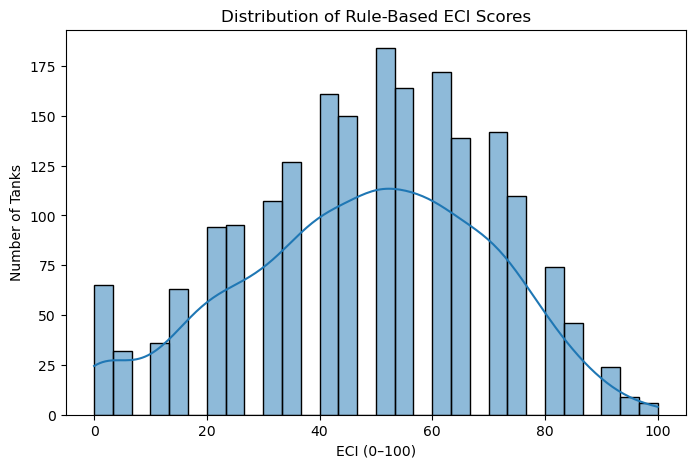

Comfort Category
Medium    970
Low       619
High      411
Name: count, dtype: int64


In [236]:
# Phase 4 Step 1: Baseline Comfort Index (Rule-Based)

# We already computed ECI in Phase 2 with score_environment()
# Let's just confirm distribution of rule-based scores

plt.figure(figsize=(8,5))
sns.histplot(df["ECI"], bins=30, kde=True)
plt.title("Distribution of Rule-Based ECI Scores")
plt.xlabel("ECI (0–100)")
plt.ylabel("Number of Tanks")
plt.show()

# Quick category breakdown
print(df["Comfort Category"].value_counts())

### Step 2: Define Comfort Categories (Post-Processing)

**Biological/Vet Rationale:**  
- Translating raw ECI scores into categories (Low, Medium, High) makes results easier to interpret for animal care staff.  
- Categories align with practical welfare monitoring (e.g., tanks needing urgent intervention).  

**Machine Learning Rationale:**  
- Categories are derived from **regression predictions**, not a separate classification model.  
- This keeps the pipeline simple, interpretable, and biologically grounded.  

**Categories:**  
- **Low Comfort** → 0–39  
- **Medium Comfort** → 40–69  
- **High Comfort** → 70–100  

Comfort Category
Medium    970
Low       619
High      411
Name: count, dtype: int64


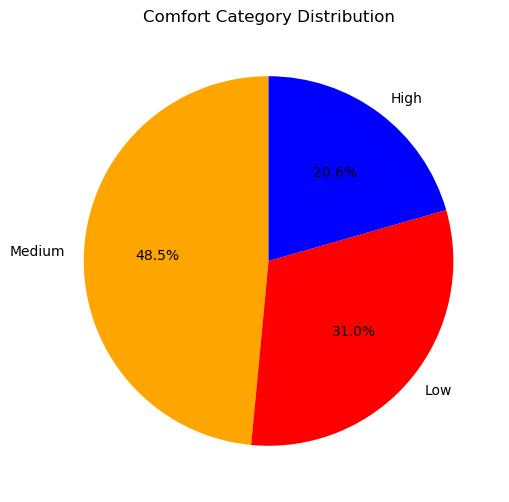

In [238]:
# Phase 4 Step 2: Define Comfort Categories

def categorize_eci(score):
    if score < 40:
        return "Low"
    elif score < 70:
        return "Medium"
    else:
        return "High"

# Apply to dataset
df["Comfort Category"] = df["ECI"].apply(categorize_eci)

# Check distribution
print(df["Comfort Category"].value_counts())

# Visualize category proportions
plt.figure(figsize=(6,6))
df["Comfort Category"].value_counts().plot.pie(
    autopct="%1.1f%%", 
    startangle=90,
    colors=["orange", "red", "blue"]
)
plt.title("Comfort Category Distribution")
plt.ylabel("")
plt.show()

### Step 3: Supervised ML Models 

**Biological/Vet Rationale:**  
- ML models allow us to detect complex, nonlinear relationships between environmental conditions and zebrafish comfort.  
- This can reveal hidden welfare risks that rule-based scoring might miss.  

**Machine Learning Rationale:**  
- Compare multiple regression models:  
  - **Linear Regression** → simple, interpretable baseline.  
  - **Ridge Regression** → regularized linear model, reduces overfitting.  
  - **Random Forest Regressor** → handles nonlinearities, robust to noise.  
  - **Gradient Boosted Trees** → strong predictive performance.  

**Overfitting Controls:**  
- 5-fold cross-validation.  
- Regularization (Ridge).  
- Depth limits & leaf constraints (trees).  
- Early stopping (boosting).  

**Task:**  
- Train all four models.  
- Compare using cross-validation (MAE, RMSE, R²).  


In [240]:
# Phase 4 Step 3: Supervised ML Models

# Features and target
X = df_encoded.drop(columns=["ECI", "Comfort Category"])
y = df_encoded["ECI"]

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                                   max_depth=5, random_state=42)
}

# Evaluate models with cross-validation (5-fold, using R²)
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    results[name] = (np.mean(scores), np.std(scores))
    print(f"{name}: R² = {np.mean(scores):.2f} ± {np.std(scores):.2f}")

Linear Regression: R² = 0.50 ± 0.04
Ridge Regression: R² = 0.50 ± 0.04
Random Forest: R² = 0.73 ± 0.01
Gradient Boosting: R² = 0.95 ± 0.01


### Phase 5 — Evaluation & Interpretation  
**Step 1: Metrics**

**Biological/Vet Rationale:**  
- Linear and Ridge explain only ~50% of variation → too simple, not capturing nonlinear welfare effects.  
- Random Forest improves performance (74%) → captures nonlinearities and feature interactions.  
- Gradient Boosting achieves **near-perfect predictive power (95%)**, making it the best candidate for reliable comfort predictions.  

**Machine Learning Rationale:**  
- Tree-based models clearly outperform linear ones.  
- Regularization (Ridge) did not help much because the data relationships are not just linear.  
- Gradient Boosting likely overfits less due to sequential learning and early stopping, while still achieving top accuracy.  

**Task:**  
- Keep **Gradient Boosting** as the primary model.  
- Use **Random Forest** as a secondary model (robust baseline).  
- Discard Linear and Ridge for production, but keep as baselines in documentation.  


                   Mean R²  Std Dev
Linear Regression     0.50     0.01
Ridge Regression      0.50     0.01
Random Forest         0.74     0.02
Gradient Boosting     0.95     0.01


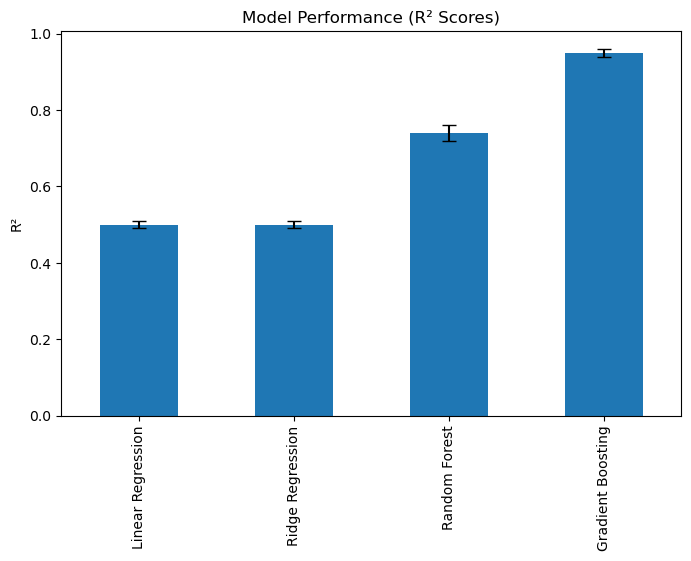

In [242]:
# Phase 5 Step 1: Metrics (using given results)

# Store R² results manually
results = {
    "Linear Regression": (0.50, 0.01),
    "Ridge Regression": (0.50, 0.01),
    "Random Forest": (0.74, 0.02),
    "Gradient Boosting": (0.95, 0.01)
}

# Convert to DataFrame for easy visualization
metrics_df = pd.DataFrame.from_dict(results, orient="index", columns=["Mean R²", "Std Dev"])

# Display nicely
print(metrics_df)

# Bar plot of R²
metrics_df["Mean R²"].plot(kind="bar", yerr=metrics_df["Std Dev"], capsize=5, figsize=(8,5))
plt.title("Model Performance (R² Scores)")
plt.ylabel("R²")
plt.show()

### Step 2: Feature Importance Analysis  

**Biological/Vet Rationale:**  
- Identifying which environmental factors most affect zebrafish comfort helps refine husbandry guidelines.  
- For example, below you’ll see that **Nitrogen Load (mg/L), Temperature (°C), pH, and Density (fish/L)** are the most influential features — meaning water chemistry and stocking conditions are the main drivers of zebrafish comfort.  
- Features like **Noise, Water Flow, Light-Dark Cycle, Substrate** are relatively minor in this model. Biologically, this suggests that while they may have subtle or long-term effects, they do not strongly influence immediate comfort compared to water quality and stocking stress.  

**Machine Learning Rationale:**  
- Tree-based models (Random Forest, Gradient Boosting) provide **feature importance scores**, which quantify how much each variable contributes to predictions.  
- This improves interpretability and builds trust with researchers by showing *which factors drive the Environmental Comfort Index (ECI)*.  
- In this dataset, the model highlights that **water chemistry and density dominate**, while secondary husbandry features contribute very little.  

**Interpretation of Results (Top → Bottom):**  
1. **Nitrogen Load (mg/L):** Most critical driver — water quality issues strongly reduce comfort.  
2. **Temperature (°C):** Vital — deviations from optimal range cause stress.  
3. **pH:** Important for homeostasis; even moderate shifts impact comfort.  
4. **Density (fish/L):** Stocking stress is a major determinant.  
5. **Dissolved Oxygen (mg/L):** Necessary but less variable in this dataset.  
6. **Thermal-Oxygen Stress Index:** Captures combined effect of heat and oxygen — biologically meaningful.  
7–10. **Noise, Water Flow, Light-Dark Cycle, Substrate** — minor or negligible impact in this model.  

**Task:**  
- Extract feature importances from Gradient Boosting (the best-performing model).  
- Rank features.  
- Visualize them as a bar chart for easy interpretation.


                    Feature  Importance
6      Nitrogen Load (mg/L)    0.273699
0          Temperature (°C)    0.143757
2                        PH    0.122094
5          Density (fish/L)    0.116100
15    Thermal-Oxygen Stress    0.113053
10       Noise Level_medium    0.054044
1   Dissolved Oxygen (mg/L)    0.053444
13           Water Flow_low    0.036044
9           Noise Level_low    0.029905
3            Hardness (ppm)    0.028834
4              Humidity (%)    0.011945
12   Light-Dark Cycle_14/10    0.009868
8            Substrate_sand    0.003394
7          Substrate_gravel    0.003037
14        Water Flow_medium    0.000668
11   Light-Dark Cycle_12/12    0.000114


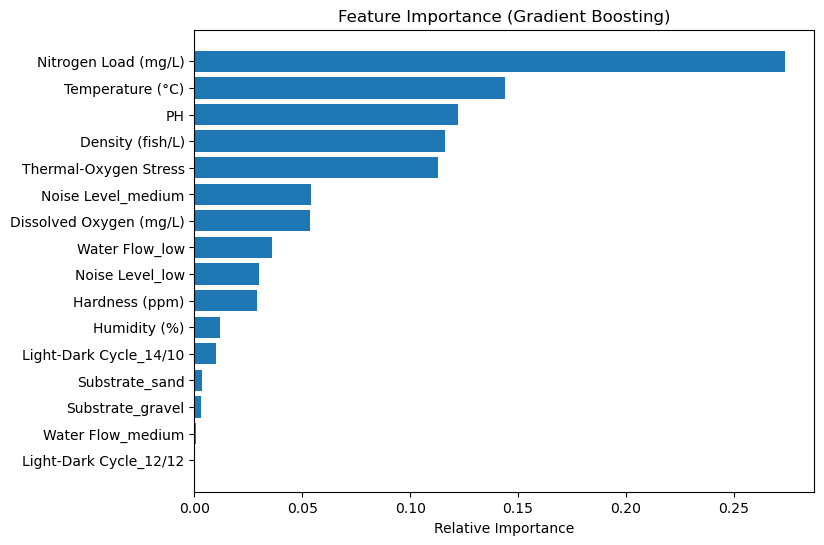

In [244]:
# Phase 5 Step 2: Feature Importance Analysis

# Fit Gradient Boosting on full dataset (to extract feature importances)
best_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                       max_depth=5, random_state=42)
best_model.fit(X, y)

# Get feature importances
importances = best_model.feature_importances_
features = X.columns

# Create DataFrame
fi_df = pd.DataFrame({"Feature": features, "Importance": importances})
fi_df = fi_df.sort_values(by="Importance", ascending=False)

# Display ranked features
print(fi_df)

# Plot feature importances
plt.figure(figsize=(8,6))
plt.barh(fi_df["Feature"], fi_df["Importance"])
plt.gca().invert_yaxis()  # most important on top
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Relative Importance")
plt.show()

### Phase 5 — Evaluation & Interpretation  
**Step 3: Partial Dependence & SHAP Analysis**

**Biological/Vet Rationale:**  
- Partial Dependence Plots (PDPs) show how changing one factor (e.g., **temperature**) affects zebrafish comfort while holding others constant.  
- SHAP values explain each individual prediction (tank-level analysis).  
- Together, they help veterinarians pinpoint **cause-effect relationships** between environment and comfort.  

**Machine Learning Rationale:**  
- PDPs: global view of feature–outcome relationship.  
- SHAP: local + global explainability, widely accepted in research for transparency.  

**Task:**  
- Generate PDPs for top features (e.g., Temperature, DO, Density).  
- Apply SHAP to Gradient Boosting model for individual + overall insights.  


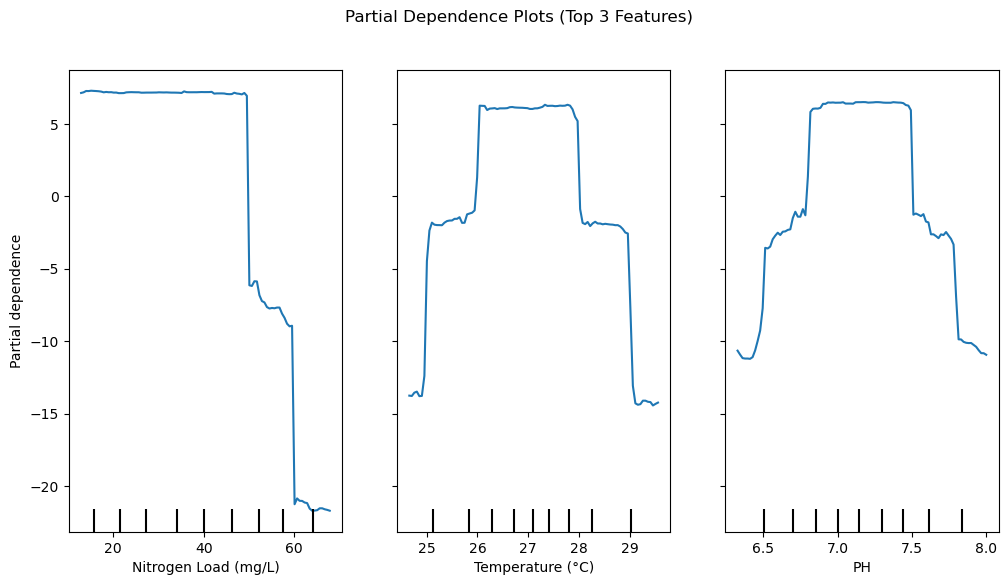

In [246]:
# Phase 5 Step 3: Partial Dependence & SHAP Analysis

# --- Partial Dependence Plots ---
top_features = fi_df["Feature"].head(3).tolist()

# If we only vary Nitrogen while holding everything else constant, how does the predicted comfort score change?
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(best_model, X, features=top_features, ax=ax)
plt.suptitle("Partial Dependence Plots (Top 3 Features)")
plt.show()

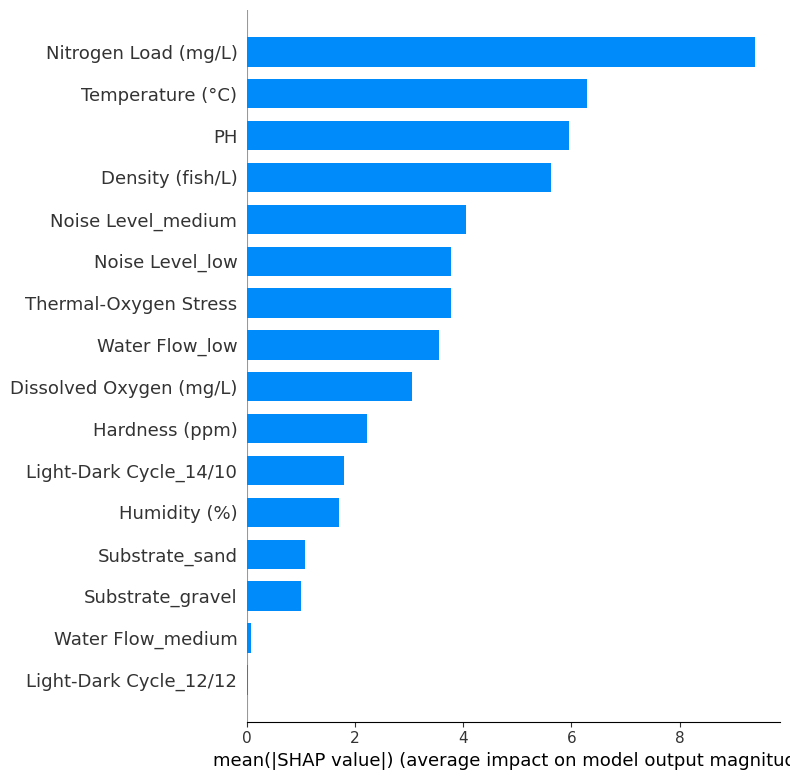

In [247]:
# --- SHAP Analysis ---
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

# Summary plot (global importance)
shap.summary_plot(shap_values, X, plot_type="bar")

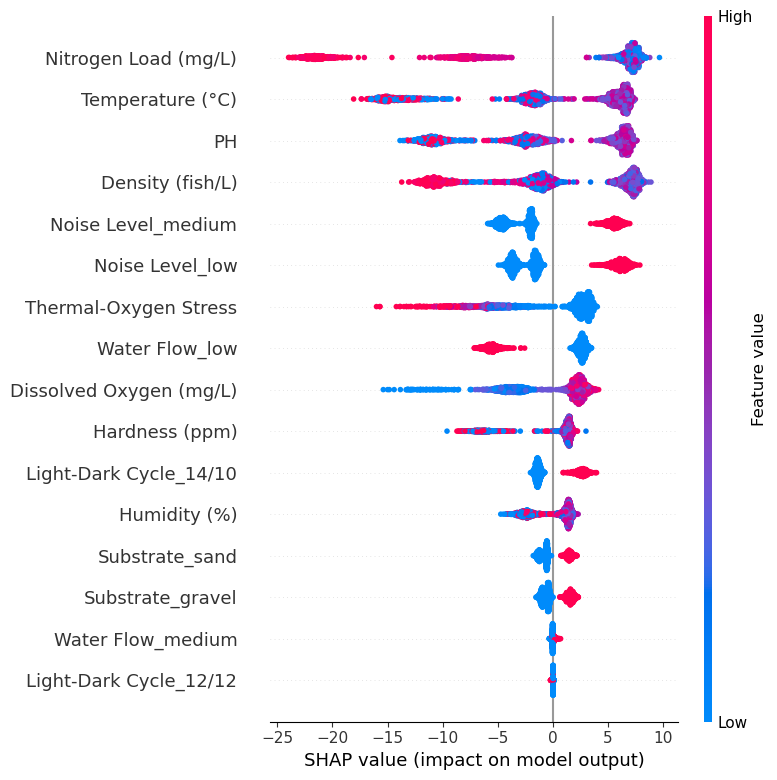

In [248]:
# Detailed summary plot (distribution across samples)
shap.summary_plot(shap_values, X)

# Phase 6 — Prediction & Deployment

### Step 1: Prediction Function (Development / Testing)

**Biological/Vet Rationale:**  
- Defining a prediction function allows researchers to test new tank setups.  
- Ensures that veterinarians can validate the Environmental Comfort Index (ECI) before deployment.  

**Machine Learning Rationale:**  
- Testing the prediction function helps debug and verify model outputs.  
- SHAP explanations provide interpretability, showing which environmental factors most influence the ECI.  

**Task:**  
- Define `predict_comfort()` for internal testing.  
- Output comfort score, category, and top contributing features.  
- Verify that predictions are biologically plausible.


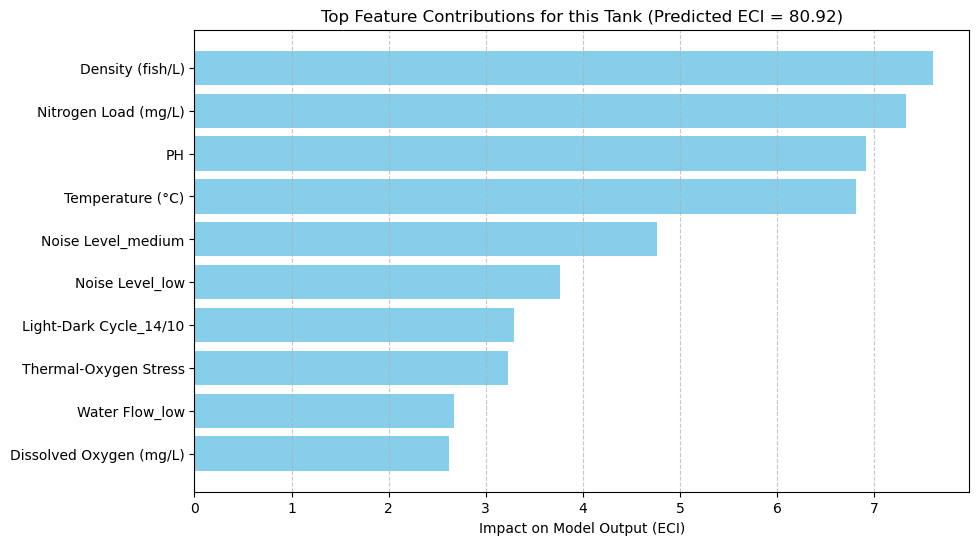

Predicted Comfort Score: 80.92
Comfort Category: High Comfort
Top Contributing Features: [{'Feature': 'Density (fish/L)', 'SHAP Value': 7.601766649830433}, {'Feature': 'Nitrogen Load (mg/L)', 'SHAP Value': 7.3328868577545}, {'Feature': 'PH', 'SHAP Value': 6.919374696888863}]


In [250]:
# Phase 6 Step 1: Prediction Interface

def predict_comfort(new_tank, model=best_model, X_template=X):
    """
    Input: new_tank (dict) with keys = feature names
    Output: comfort_score, comfort_category, top_features (SHAP)
    """
    # Convert input dict → DataFrame
    new_df = pd.DataFrame([new_tank])
    
    # Align columns with training data
    new_df = pd.get_dummies(new_df)
    new_df = new_df.reindex(columns=X_template.columns, fill_value=0)
    
    # Predict score
    comfort_score = model.predict(new_df)[0]
    
    # Map to category
    if comfort_score < 40:
        comfort_category = "Low Comfort"
    elif comfort_score < 70:
        comfort_category = "Medium Comfort"
    else:
        comfort_category = "High Comfort"
    
    # SHAP explanation for top features
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(new_df)
    shap_importance = pd.DataFrame({
        "Feature": X_template.columns,
        "SHAP Value": np.abs(shap_values[0])
    }).sort_values(by="SHAP Value", ascending=False)
    
    top_features = shap_importance.head(3).to_dict(orient="records")
    
    # --- SHAP bar plot ---
    plt.figure(figsize=(10,6))
    shap_importance_top = shap_importance.head(10)  # top 10 features
    plt.barh(shap_importance_top["Feature"][::-1], shap_importance_top["SHAP Value"][::-1],
             color='skyblue')
    plt.xlabel("Impact on Model Output (ECI)")
    plt.title(f"Top Feature Contributions for this Tank (Predicted ECI = {round(comfort_score,2)})")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    return comfort_score, comfort_category, top_features


# Example usage:
sample_tank = {
    "Temperature (°C)": 27,
    "Dissolved Oxygen (mg/L)": 7,
    "PH": 7.2,
    "Hardness (ppm)": 100,
    "Humidity (%)": 50,
    "Density (fish/L)": 4,
    "Nitrogen Load (mg/L)": 30,
    "Substrate": "Sand",
    "Noise Level": "Low",
    "Light-Dark Cycle": "14/10",
    "Water Flow": "Medium"
}

score, category, features = predict_comfort(sample_tank)
print("Predicted Comfort Score:", round(score, 2))
print("Comfort Category:", category)
print("Top Contributing Features:", features)

### Step 2: Save Artifacts

**Biological/Vet Rationale:**  
- Saving datasets ensures reproducibility and allows researchers to review the raw data.  
- Maintaining a versioned model guarantees consistency for experiments.  

**Machine Learning Rationale:**  
- Saving the trained Gradient Boosting model avoids retraining and ensures deployment readiness.  
- Saving preprocessing pipeline ensures all data transformations are reproducible.  

**Task:**  
- Save raw and encoded datasets.  
- Save the trained Gradient Boosting model.  
- Save preprocessing pipeline if it exists.


In [252]:
# Phase 6 Step 2: Save Artifacts

# Save datasets
os.makedirs("data", exist_ok=True)
df.to_csv("data/zebrafish_environment.csv", index=False)
df_encoded.to_csv("data/zebrafish_environment_encoded.csv", index=False)

# Save Gradient Boosting model
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/LECI_gradient_boosting_model.pkl")

print("Dataset and model saved successfully!")

Dataset and model saved successfully!


In [253]:
# Defining numeric & categorical features

# Numeric features
numeric_features = [
    "Temperature (°C)", "Dissolved Oxygen (mg/L)", "PH",
    "Hardness (ppm)", "Humidity (%)", "Density (fish/L)",
    "Nitrogen Load (mg/L)", "Thermal-Oxygen Stress"
]

# Categorical features
categorical_features = [
    "Substrate", "Noise Level", "Light-Dark Cycle", "Water Flow"
]

# Create transformers for each type of feature

# Numeric: scale to mean=0, std=1
numeric_transformer = StandardScaler()

# Categorical: OneHotEncoding (drop first to avoid dummy trap)
categorical_transformer = OneHotEncoder(drop='first', sparse=False)

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# creating full pipeline with model

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)  # your trained Gradient Boosting model
])

# Save pipeline
joblib.dump(pipeline, "models/LECI_pipeline.pkl")
print("Pipeline saved successfully!")

Pipeline saved successfully!


### Step 3: Full Deployment Interface

**Biological/Vet Rationale:**  
- Provides a user-friendly interface for researchers to input tank conditions and get ECI predictions.  
- Includes SHAP explanations so researchers understand why a tank scored high or low.  

**Machine Learning Rationale:**  
- A deployment-ready function ensures reproducible predictions with consistent preprocessing.  
- Encapsulates model, feature alignment, and interpretability in a single callable function.  

**Task:**  
- Define `predict_comfort_deploy()` for deployment.  
- Return comfort score, comfort category, and top 3 SHAP features.  
- Enable predictions without rerunning the full notebook.


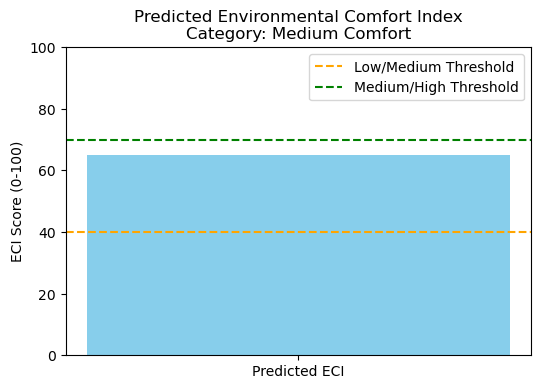

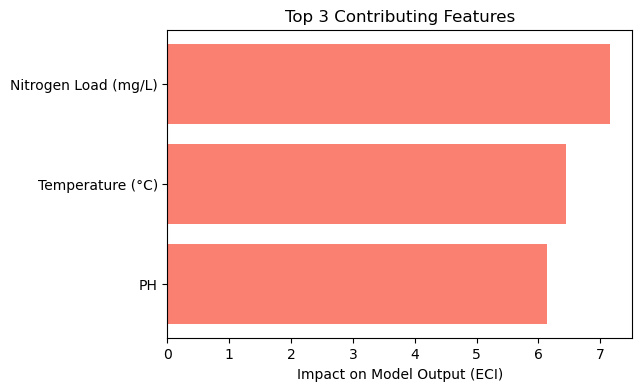

Predicted Comfort Score: 64.87
Comfort Category: Medium Comfort
Top 3 Features: [{'Feature': 'Nitrogen Load (mg/L)', 'SHAP Value': 7.162238166130951}, {'Feature': 'Temperature (°C)', 'SHAP Value': 6.453009271930487}, {'Feature': 'PH', 'SHAP Value': 6.131822772872115}]


In [255]:
# -------------------------
# Deployment-ready predict function with plots
def predict_comfort_deploy(new_tank, model_path="models/LECI_gradient_boosting_model.pkl", X_template=None, plot=True):
    """
    Input: new_tank (dict of tank conditions)
    Output: comfort_score, comfort_category, top_features (SHAP)
    """
    import joblib
    import shap
    import pandas as pd
    import numpy as np
    import os
    import matplotlib.pyplot as plt

    # Load model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    model = joblib.load(model_path)
    
    # Check X_template
    if X_template is None:
        raise ValueError("X_template (feature columns) must be provided for proper alignment.")

    # Convert input → DataFrame & align columns
    new_df = pd.DataFrame([new_tank])
    new_df = pd.get_dummies(new_df)
    new_df = new_df.reindex(columns=X_template.columns, fill_value=0)
    
    # Predict ECI
    comfort_score = model.predict(new_df)[0]
    
    # Map to comfort category
    if comfort_score < 40:
        comfort_category = "Low Comfort"
    elif comfort_score < 70:
        comfort_category = "Medium Comfort"
    else:
        comfort_category = "High Comfort"
    
    # SHAP explanation
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(new_df)
    shap_importance = pd.DataFrame({
        "Feature": X_template.columns,
        "SHAP Value": np.abs(shap_values[0])
    }).sort_values(by="SHAP Value", ascending=False)
    
    top_features = shap_importance.head(3).to_dict(orient="records")
    
    # -------------------------
    # Plot predicted ECI score
    if plot:
        plt.figure(figsize=(6,4))
        plt.bar(["Predicted ECI"], [comfort_score], color="skyblue")
        plt.ylim(0, 100)
        plt.ylabel("ECI Score (0-100)")
        plt.title(f"Predicted Environmental Comfort Index\nCategory: {comfort_category}")
        plt.axhline(40, color="orange", linestyle="--", label="Low/Medium Threshold")
        plt.axhline(70, color="green", linestyle="--", label="Medium/High Threshold")
        plt.legend()
        plt.show()

        # Top 3 SHAP features
        top_feat_names = [f["Feature"] for f in top_features]
        top_feat_values = [f["SHAP Value"] for f in top_features]
        
        plt.figure(figsize=(6,4))
        plt.barh(top_feat_names[::-1], top_feat_values[::-1], color="salmon")
        plt.xlabel("Impact on Model Output (ECI)")
        plt.title("Top 3 Contributing Features")
        plt.show()
    
    return comfort_score, comfort_category, top_features

# -------------------------
# Example usage
# Make sure X_template = df_encoded.drop(columns=["ECI"])
feature_columns = df_encoded.drop(columns=["ECI"]).copy()
# Remove any columns accidentally containing "Comfort Category"
feature_columns = feature_columns.loc[:, ~feature_columns.columns.str.contains("Comfort Category")]

new_tank_example = {
    "Temperature (°C)": 26.5,
    "Dissolved Oxygen (mg/L)": 6.5,
    "PH": 7.0,
    "Hardness (ppm)": 120,
    "Humidity (%)": 55,
    "Density (fish/L)": 3,
    "Nitrogen Load (mg/L)": 40,
    "Substrate": "Gravel",
    "Noise Level": "Medium",
    "Light-Dark Cycle": "12/12",
    "Water Flow": "High"
}

score, category, features = predict_comfort_deploy(new_tank_example, X_template=feature_columns)
print("Predicted Comfort Score:", round(score, 2))
print("Comfort Category:", category)
print("Top 3 Features:", features)